In [ ]:
#!pip install opendatasets
#import opendatasets as od
#od.download("https://www.kaggle.com/sherinclaudia/sarcastic-comments-on-reddit")

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse import hstack
import scipy.sparse as sp
import seaborn as sns
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
import gc
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import accuracy_score,confusion_matrix,plot_confusion_matrix,roc_auc_score
from sklearn.calibration import CalibratedClassifierCV

In [8]:
import pickle

In [3]:
pickle.__version__

AttributeError: module 'pickle' has no attribute '__version__'

In [ ]:
pd.__version__

In [ ]:
pickle.__version__

In [ ]:
joblib.__version__

In [ ]:
import tensorflow as tf
tf.__version__

# EDA

In [9]:
data= pd.read_csv("sarcastic-comments-on-reddit/train-balanced-sarcasm.csv")
data.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd prefer is she lived in NC as well."
1,0,You do know west teams play against west teams more than east teams right?,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 seed) did not even carry a good enough record to make the playoffs in the east last year.
2,0,"They were underdogs earlier today, but since Gronk's announcement this afternoon, the Vegas line has moved to patriots -1",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york nigga"" ones are.",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for that. It was made by our boy EASports_MUT


In [10]:
data.shape

(1010826, 10)

In [11]:
data.dtypes

label              int64
comment           object
author            object
subreddit         object
score              int64
ups                int64
downs              int64
date              object
created_utc       object
parent_comment    object
dtype: object

In [12]:
#checking NULL values

In [13]:
data.isna().sum()

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

- > Only comment has NULL values.

In [14]:
#Lets check those

data[data.comment.isna()].head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
56269,1,NaN,SodokuIRL,leagueoflegends,1,1,0,2016-09,2016-09-28 08:23:04,"LPL shitshow, EU LCS shitshow. What isn't a shitshow then?"
68590,1,NaN,TossTheDog,westchesterpa,1,-1,-1,2016-10,2016-10-11 20:25:52,Car fires smell delicious to you? You should probably get checked out.
135348,0,NaN,So12rovv,R6STeams,1,-1,-1,2016-12,2016-12-22 17:24:05,Will do. EU or NA?
199910,0,NaN,Khvostov_7g-02,tf2,1,1,0,2016-05,2016-05-16 05:46:43,"woah, thanks."
258718,1,NaN,PeaceLovePositivity,vaporents,5,5,0,2016-06,2016-06-22 20:37:11,"No, doing drugs while forming a fetus (your kid's body) is very safe and recommended."


In [15]:
data.dropna(inplace=True)

In [16]:
# I think we can drop those

# label 

In [17]:
data.label.value_counts()

0    505405
1    505368
Name: label, dtype: int64

- labels are in same weights

- 1 means Sarcastic and 

- 0 means not Sarcastic

# comment

In [18]:
data[['label','comment']]

,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams more than east teams right?
2,0,"They were underdogs earlier today, but since Gronk's announcement this afternoon, the Vegas line has moved to patriots -1"
3,0,"This meme isn't funny none of the ""new york nigga"" ones are."
4,0,I could use one of those tools.
...,...,...
1010821,1,I'm sure that Iran and N. Korea have the technology to create a pig/bird/human hybrid virus.
1010822,1,"whatever you do, don't vote green!"
1010823,1,Perhaps this is an atheist conspiracy to make Christians look bad?
1010824,1,The Slavs got their own country - it is called Kosovo


# lets check about repetition of sarcastic and non sarcastic comments

In [19]:
comment_count_no_sarcastic= data[data['label']==0].groupby('comment').size()

In [20]:
comment_count_sarcastic= data[data['label']==1].groupby('comment').size()

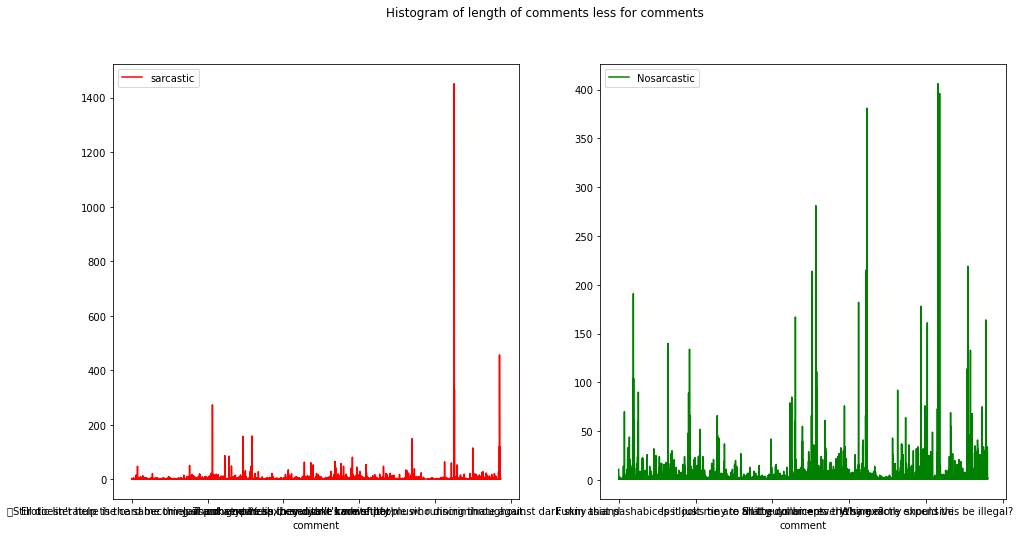

In [21]:

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
comment_count_sarcastic.plot(label='sarcastic',color='red')
#plt.axis('off')
plt.legend()
plt.subplot(1,2,2)
comment_count_no_sarcastic.plot(label='Nosarcastic',color='green')

plt.suptitle("Histogram of length of comments less for comments")
plt.legend()


In [22]:
del comment_count_no_sarcastic,comment_count_sarcastic
gc.collect()

45

- > So we can see the sarcastic comments repeats more than non sarcastc comments because people use to read,laungh,remember and paste the sarcastic comments whenever they see it fitting in any such situations

In [23]:
### We havent clean the sentense yet but lets see its "Length of comment distrubution" distribution

In [24]:
data['len_comments']= data['comment'].apply( lambda x : len(x.split()))

In [25]:
data.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,len_comments
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd prefer is she lived in NC as well.",3
1,0,You do know west teams play against west teams more than east teams right?,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 seed) did not even carry a good enough record to make the playoffs in the east last year.,14
2,0,"They were underdogs earlier today, but since Gronk's announcement this afternoon, the Vegas line has moved to patriots -1",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.,19
3,0,"This meme isn't funny none of the ""new york nigga"" ones are.",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz,12
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for that. It was made by our boy EASports_MUT,7


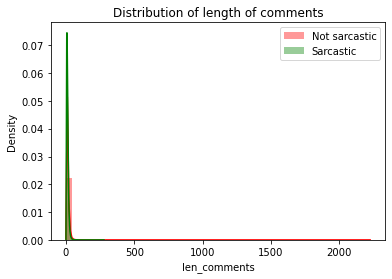

In [43]:
## for sarcastic comments

sns.distplot(data[data['label']==0]["len_comments"],color="red",label="Not sarcastic")
sns.distplot(data[data['label']==1]["len_comments"],color="green",label="Sarcastic")
plt.title("Distribution of length of comments")
plt.legend()

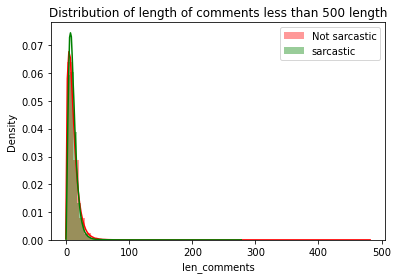

In [44]:
# we can see Non sacrcasric comments are seems to smaller than the sarcastic ones ,we will try to apply more filter and check

sns.distplot(data[(data['label']==0) & (data['len_comments']<500)]["len_comments"],color="red",label="Not sarcastic")
sns.distplot(data[(data['label']==1) & (data['len_comments']<500)]["len_comments"],color="green",label="sarcastic")
plt.title("Distribution of length of comments less than 500 length")
plt.legend()

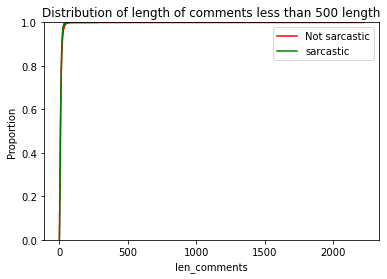

In [45]:
sns.ecdfplot(data[(data['label']==0)]["len_comments"],color="red",label="Not sarcastic")
sns.ecdfplot(data[(data['label']==1)]["len_comments"],color="green",label="sarcastic")
plt.title("Distribution of length of comments less than 500 length")
plt.legend()

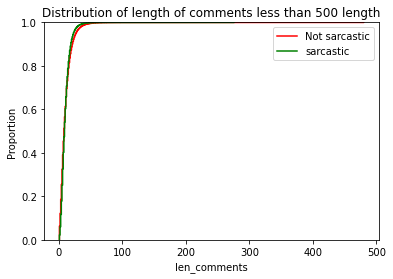

In [46]:
sns.ecdfplot(data[(data['label']==0) & (data['len_comments']<500)]["len_comments"],color="red",label="Not sarcastic")
sns.ecdfplot(data[(data['label']==1) & (data['len_comments']<500)]["len_comments"],color="green",label="sarcastic")
plt.title("Distribution of length of comments less than 500 length")
plt.legend()

In [47]:
np.percentile(data[(data['label']==0)]["len_comments"].values,99)

42.0

In [48]:
np.percentile(data[(data['label']==1)]["len_comments"].values,99)

34.0

<AxesSubplot:xlabel='label', ylabel='len_comments'>

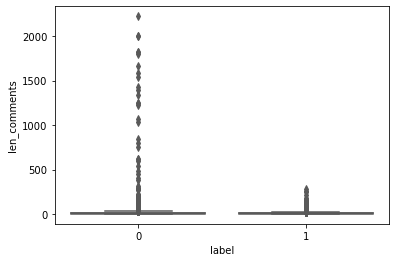

In [49]:
sns.boxplot(data=data,x='label',y='len_comments',palette='Set2')

In [50]:
#Its quite clear now

####  Wordcloud of comments


Text(0.5, 1.0, 'Wordcloud of Neutral comments')

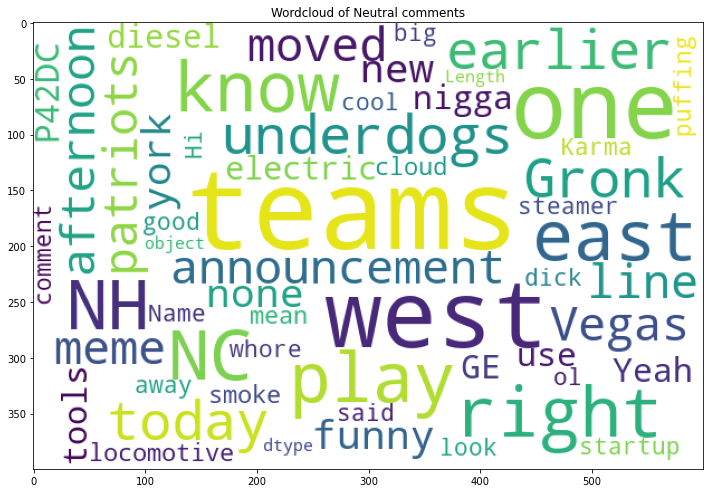

In [51]:
wordcloud_scarstic = WordCloud(background_color='white', stopwords = STOPWORDS,
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=600, height=400)

plt.figure(figsize=(12, 12))
wordcloud_scarstic.generate(str(data.loc[data['label'] == 0, 'comment']))
plt.grid(b= False)
plt.imshow(wordcloud_scarstic)
plt.title("Wordcloud of Neutral comments")

Text(0.5, 1.0, 'Wordcloud of Sarcastic comments')

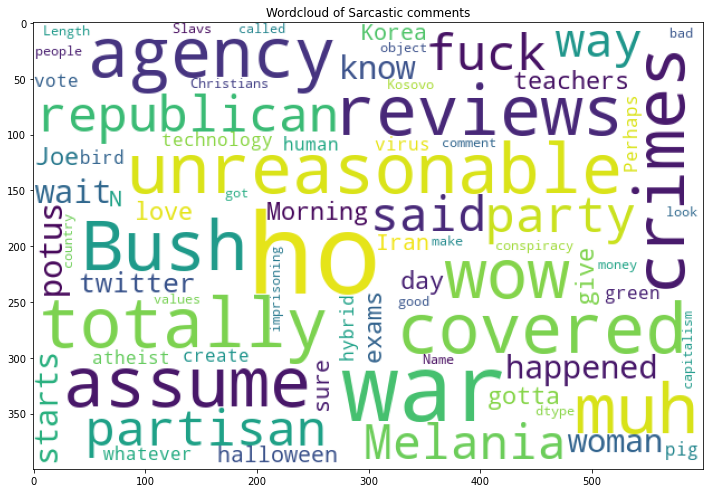

In [52]:
wordcloud_No_sarcastic = WordCloud(background_color='white', stopwords = STOPWORDS,
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=600, height=400)

plt.figure(figsize=(12, 12))
wordcloud_No_sarcastic.generate(str(data.loc[data['label'] == 1, 'comment']))
plt.grid(b= False)
plt.imshow(wordcloud_No_sarcastic)
plt.title("Wordcloud of Sarcastic comments")

In [53]:
#we will come back to this lagter again but lets see other well

Text(0.5, 1.0, 'Heatmap for correlations')

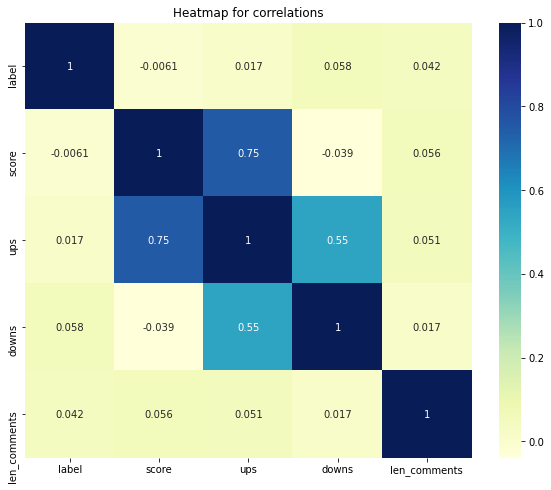

In [54]:
# Correlations
plt.figure(figsize=(10,8))
corr = data.corr(method = 'spearman')
sns.heatmap(corr,annot = True,cmap='YlGnBu')
plt.title("Heatmap for correlations")

In [55]:
# There are actually just two highly correlated columns

#ups and score

In [56]:
data.columns

Index(['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs',
       'date', 'created_utc', 'parent_comment', 'len_comments'],
      dtype='object')

In [57]:
### author

Text(0.5, 1.0, 'CDF for  authors and their count of comments')

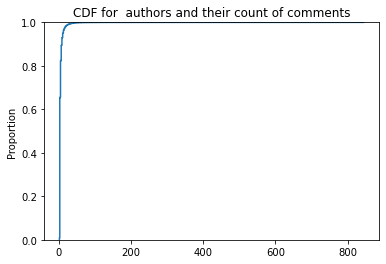

In [58]:
sns.ecdfplot(data['author'].value_counts().sort_values(ascending=False).values)
plt.title("CDF for  authors and their count of comments")

Text(0.5, 1.0, 'Boxplot for  authors and their count of comments')

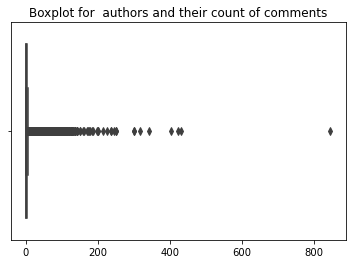

In [59]:
sns.boxplot(data['author'].value_counts().sort_values(ascending=False).values)
plt.title("Boxplot for  authors and their count of comments")

In [60]:
#Most author's have comment are between 1 to 200 times for a author rest some authoers have more comments

<AxesSubplot:>

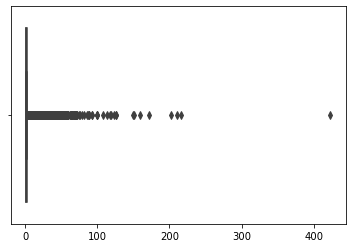

In [61]:
sns.boxplot(data[data['label']==0]['author'].value_counts().sort_values(ascending=False).values)

<AxesSubplot:>

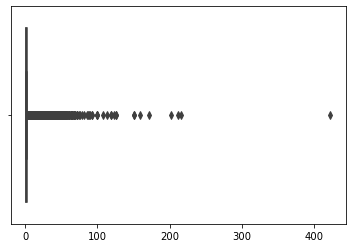

In [62]:
sns.boxplot(data[data['label']==1]['author'].value_counts().sort_values(ascending=False).values)

In [63]:
#https://stackoverflow.com/questions/29836836/how-do-i-filter-a-pandas-dataframe-based-on-value-counts
data[data.groupby("author")['author'].transform('size') > 200]['author'].value_counts()

Biffingston         845
pokemon_fetish      432
NeonDisease         422
ShyBiDude89         404
ivsciguy            342
mad-n-fla           318
mindlessrabble      302
Canada_girl         300
Chaoslab            252
sleaze_bag_alert    251
tau-lepton          246
Bipolarruledout     238
IrishJoe            236
gonzone             226
InFearn0            216
Name: author, dtype: int64

In [64]:
#So these are most active guys on reddit 
#lets see who is more sarcastic

In [65]:
list(data[data.groupby("author")['author'].transform('size') > 200]['author'].unique())

['ivsciguy',
 'sleaze_bag_alert',
 'Chaoslab',
 'ShyBiDude89',
 'tau-lepton',
 'mindlessrabble',
 'Biffingston',
 'mad-n-fla',
 'InFearn0',
 'gonzone',
 'pokemon_fetish',
 'NeonDisease',
 'IrishJoe',
 'Bipolarruledout',
 'Canada_girl']

In [66]:
most_commenting_authors=list(data[data.groupby("author")['author'].transform('size') > 200]['author'].unique())

In [67]:
authors={}

for i in most_commenting_authors:
    authors[i]=[len(data[(data['label']==1) & (data['author']==i)]),len(data[(data['label']==0) & (data['author']==i)])]

In [68]:
authors

{'ivsciguy': [171, 171],
 'sleaze_bag_alert': [125, 126],
 'Chaoslab': [126, 126],
 'ShyBiDude89': [202, 202],
 'tau-lepton': [123, 123],
 'mindlessrabble': [151, 151],
 'Biffingston': [422, 423],
 'mad-n-fla': [159, 159],
 'InFearn0': [108, 108],
 'gonzone': [113, 113],
 'pokemon_fetish': [216, 216],
 'NeonDisease': [211, 211],
 'IrishJoe': [118, 118],
 'Bipolarruledout': [119, 119],
 'Canada_girl': [150, 150]}

In [69]:
#So there is no clear indication with authours name that It could be sarcastic,because bot type of comments are almost same.

In [70]:
data.columns

Index(['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs',
       'date', 'created_utc', 'parent_comment', 'len_comments'],
      dtype='object')

# subreddit

In [71]:
data['subreddit'].value_counts()

AskReddit           65674
politics            39493
worldnews           26376
leagueoflegends     21034
pcmasterrace        18987
                    ...  
stockaday               1
VFIO                    1
bizarrebuildings        1
lunalanieee             1
DiversitySMP            1
Name: subreddit, Length: 14876, dtype: int64

<AxesSubplot:>

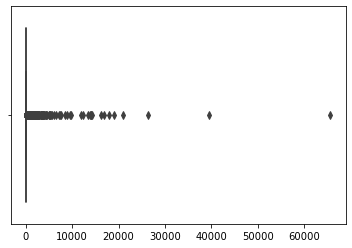

In [72]:
sns.boxplot(data['subreddit'].value_counts().sort_values(ascending=False).values)

In [73]:
# Getting the top 5 popular subreddits
data['subreddit'].value_counts()[:5]

AskReddit          65674
politics           39493
worldnews          26376
leagueoflegends    21034
pcmasterrace       18987
Name: subreddit, dtype: int64

In [74]:
top_reddits =data['subreddit'].value_counts()[:5].index.to_list()

In [75]:
subreddit = pd.DataFrame()
subreddit['subreddit'] = top_reddits
subreddit['sarcastic'] = np.nan
subreddit['neutral'] = np.nan
subreddit['total'] = np.nan

for i in range(len(top_reddits)):
    subreddit.loc[i,'subreddit']= top_reddits[i]
    subreddit.loc[i,'sarcastic']= len(data[(data['subreddit']==top_reddits[i]) & (data['label']==1)])
    subreddit.loc[i,'neutral']= len(data[(data['subreddit']==top_reddits[i]) & (data['label']==0)])
    subreddit.loc[i,'total']= len(data[(data['subreddit']==top_reddits[i])])


In [76]:
subreddit

,subreddit,sarcastic,neutral,total
0,AskReddit,26365.0,39309.0,65674.0
1,politics,23907.0,15586.0,39493.0
2,worldnews,16947.0,9429.0,26376.0
3,leagueoflegends,11407.0,9627.0,21034.0
4,pcmasterrace,10759.0,8228.0,18987.0


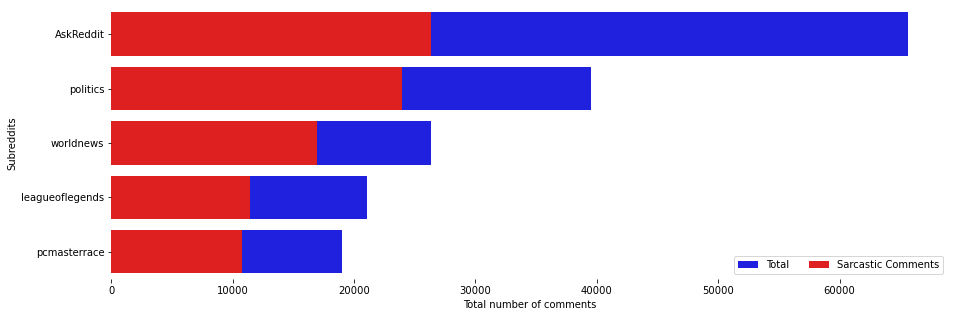

In [77]:
# Initialize the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 5))
# Plot the total comments for the subreddits
sns.barplot(x="total", y="subreddit", data=subreddit,label="Total", color="b")
# Plot the total sarcastic comments for the subreddits
sns.barplot(x="sarcastic", y="subreddit", data=subreddit,label="Sarcastic Comments", color="r")
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set( ylabel="Subreddits",xlabel="Total number of comments")
sns.despine(left=True, bottom=True)

# score 



In [78]:
data['score'].describe()

count    1.010773e+06
mean     6.885999e+00
std      4.834411e+01
min     -5.070000e+02
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      9.070000e+03
Name: score, dtype: float64

<AxesSubplot:xlabel='score', ylabel='Density'>

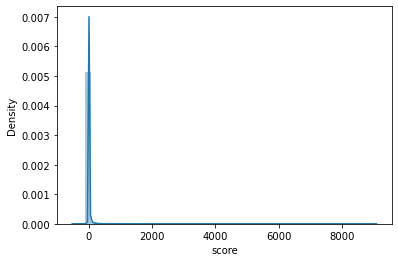

In [79]:
sns.distplot(data['score'])

Text(0.5, 1.0, 'CDF plot for Scores')

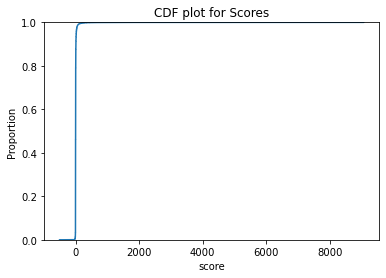

In [80]:
sns.ecdfplot(data['score'])
plt.title("CDF plot for Scores")


In [81]:
np.percentile(data['score'],99)

88.0

In [82]:
#So 99% values lies below 88 

In [83]:
#Popularity of the comments according to being sarcastic
#With the help of the score of the comments, we can determine whether the sarcastic comments are more popular in Reddit discussions.
sarcasm_score = np.array(data.loc[data['label'] == 1]['score'])
neutral_score = np.array(data.loc[data['label'] == 0]['score'])

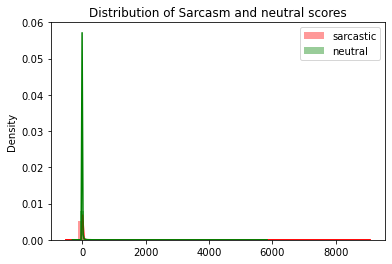

In [84]:
# we can see Non sacrcasric comments are seems to smaller than the sarcastic ones ,we will try to apply more filter and check

sns.distplot(sarcasm_score,color="red",label="sarcastic")
sns.distplot(neutral_score,color="green",label="neutral")
plt.title("Distribution of Sarcasm and neutral scores")
plt.legend()

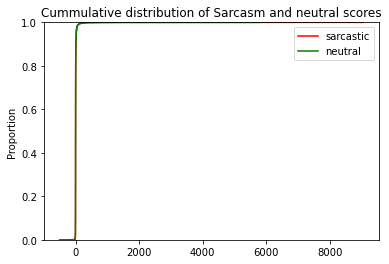

In [85]:
sns.ecdfplot(sarcasm_score,color="red",label="sarcastic")
sns.ecdfplot(neutral_score,color="green",label="neutral")
plt.title("Cummulative distribution of Sarcasm and neutral scores")
plt.legend()

<AxesSubplot:ylabel='score'>

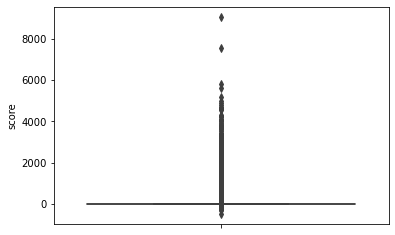

In [86]:
sns.boxplot(y=data['score'])

In [87]:
np.percentile(data['score'],99)

88.0

<AxesSubplot:ylabel='score'>

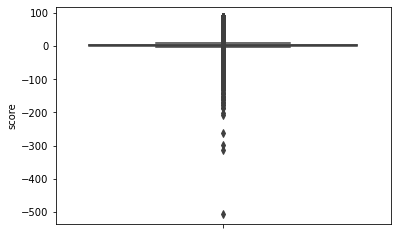

In [88]:
sns.boxplot(y=data[data['score']<= np.percentile(data['score'],99)]['score'])
#data[data['score']<= np.percentile(data['score'],99)]

## Ups 

In [89]:
data['ups'].describe()

count    1.010773e+06
mean     5.499140e+00
std      4.127402e+01
min     -5.070000e+02
25%      0.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      5.163000e+03
Name: ups, dtype: float64

Text(0.5, 1.0, 'Distribution of Upvotes')

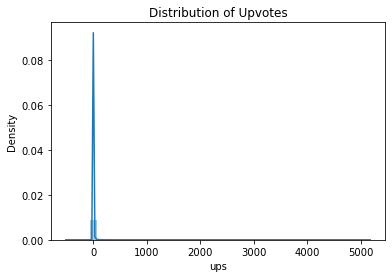

In [90]:
sns.distplot(data['ups'])
plt.title("Distribution of Upvotes")

Text(0.5, 1.0, 'CDF plot for Scores')

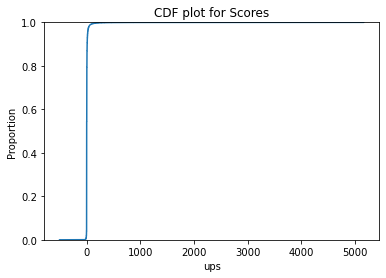

In [91]:
sns.ecdfplot(data['ups'])
plt.title("CDF plot for Scores")

In [92]:
np.percentile(data['score'],99)


88.0

- > So 99% values lies below 88 

In [93]:
np.percentile(data['score'],5)

-1.0

In [94]:
#only 5% values lies below -1.0

In [95]:
#Popularity of the comments according to being sarcastic
#With the help of the ups of the comments, we can determine whether the sarcastic comments are more popular in Reddit discussions.
sarcasm_score = np.array(data.loc[data['label'] == 1]['ups'])
neutral_score = np.array(data.loc[data['label'] == 0]['ups'])

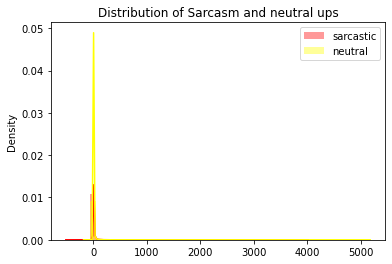

In [96]:
# we can see Non sacrcasric comments are seems to smaller than the sarcastic ones ,we will try to apply more filter and check


sns.distplot(sarcasm_score,color="red",label="sarcastic")
sns.distplot(neutral_score,color="yellow",label="neutral")
plt.title("Distribution of Sarcasm and neutral ups")
plt.legend()

- > Mosly the high ups comments are neutral ones. Yeah it happens because people upvotes the things which make more sense. But on the same time,These are just outliers.

- > Again There are also some negtaive upvotes are for only sarcastic comments but we can see there are also negative ups for neurtral comment. I think on name of sarcasm ,people write some very dark things,That can be negative too but its rare, for some very messed up minds.


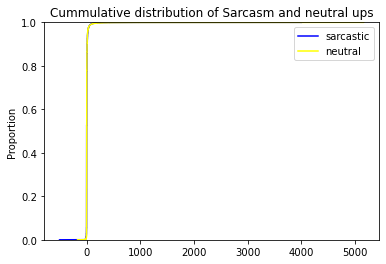

In [97]:
sns.ecdfplot(sarcasm_score,color="blue",label="sarcastic")
sns.ecdfplot(neutral_score,color="yellow",label="neutral")
plt.title("Cummulative distribution of Sarcasm and neutral ups")
plt.legend()

## Ups 

In [98]:
data['downs'].describe()

count    1.010773e+06
mean    -1.458686e-01
std      3.529746e-01
min     -1.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      0.000000e+00
Name: downs, dtype: float64

In [99]:
data['downs'].value_counts()

 0    863333
-1    147440
Name: downs, dtype: int64

Text(0.5, 1.0, 'Distribution of downs')

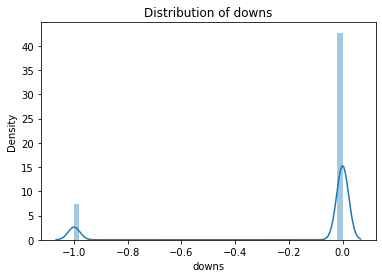

In [100]:
sns.distplot(data['downs'])
plt.title("Distribution of downs")

Text(0.5, 1.0, 'CDF plot for downs')

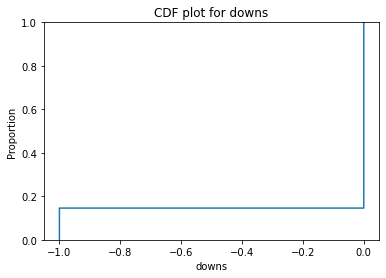

In [101]:
sns.ecdfplot(data['downs'])
plt.title("CDF plot for downs")

- > only like 17 to 18% are -1 rest are 0

In [102]:
#downvotes  of the comments according to being sarcastic
#With the help of the downs of the comments, we can determine whether the sarcastic comments are more popular in Reddit discussions.
sarcasm_score = np.array(data.loc[data['label'] == 1]['downs'])
neutral_score = np.array(data.loc[data['label'] == 0]['downs'])

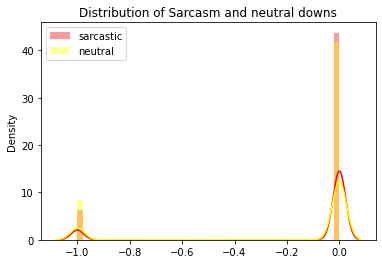

In [103]:
sns.distplot(sarcasm_score,color="red",label="sarcastic")
sns.distplot(neutral_score,color="yellow",label="neutral")
plt.title("Distribution of Sarcasm and neutral downs")
plt.legend()

- > Both type of comments have simliar distribution

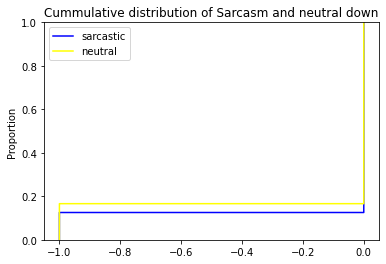

In [104]:
sns.ecdfplot(sarcasm_score,color="blue",label="sarcastic")
sns.ecdfplot(neutral_score,color="yellow",label="neutral")
plt.title("Cummulative distribution of Sarcasm and neutral down")
plt.legend()

- >  I dont think its a relevant feature.

# Final observations after EDA


- We can see the sarcastic comments repeats more than non sarcastc comments because people use to read,laungh,remember and paste the sarcastic comments whenever they see it fitting in any such situations

- There are actually just two highly correlated columns : Ups and score ,which is just obivous
    
    
- Most author's have comment are between 1 to 200 times for a author rest some authoers have more comments.


-  There is no clear indication with authours name that It could be sarcastic,because bot type of comments are almost same.


- There is no clear indication with most popular name that It could be sarcastic,because both type of comments are almost same.

- Mosly the high ups comments are neutral ones. Yeah it happens because people upvotes the things which make more sense. But on the same time,These are just outliers.


- Again There are also some negtaive upvotes are for only sarcastic comments but we can see there are also negative ups for neurtral comment. I think on name of sarcasm ,people write some very dark things,That can be negative too but its rare, for some very messed up minds.


- only like 17 to 18% are -1 rest are 0 for downs


-  Type of comments have simliar distribution for downs

- There is no indication that upvotes, downvotes and scores have any different distribution for diffent types of comments







## <font color='green'> <i>I strongly think better than using all these features which carries kind of ambigous impact in order to predict the comment is sarcastic or not .We can use our best NLP techniques.So we can talk about it later and start only cleaing the comments columns. So like in a real time problem we can just read the comments and say .. yeah its funny or sarcastic in a way. </i></font>

##  Data preprocessing

In [106]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

In [ ]:
def removeHtmlTagWithBS4(phrase):
    soup= BeautifulSoup(phrase,'lxml')
    text= soup.get_text()
    return text

In [ ]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

In [ ]:
from nltk.corpus import stopwords
from tqdm import tqdm
import re
stopwords = stopwords.words('english')

def preprocess(text):
    sentence=""
    sentence=str(text)
    sentence= removeHtmlTagWithBS4(sentence)
    sent = sentence.replace('\\r', ' ')
    # Replace "quotes" with "space".
    sent = sent.replace('\\"', ' ')
    # Replace "line feed" with "space".
    sent = sent.replace('\\n', ' ')
    # Replace characters between words with "space".
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent=decontractions(sent)            
    sent=sent.lower().strip()
        
    return sent

In [ ]:
data= data[['label','comment']]

In [ ]:
data['clean_comment']= data['comment'].apply(preprocess)

In [ ]:
data.head()

In [ ]:
data[data['clean_comment']==""]

In [ ]:
data[data['clean_comment']!=""][['label']

In [ ]:
data[data['clean_comment']!=""][['label','clean_comment']].to_csv("preprocessed.csv",index=None)

In [ ]:
del data

In [108]:
import gc
gc.collect()

30

In [59]:
df=  pd.read_csv("preprocessed.csv",index_col=None)
df.head()

,label,clean_comment
0,0,nc and nh
1,0,you do know west teams play against west teams more than east teams right
2,0,they were underdogs earlier today but since gronk s announcement this afternoon the vegas line has moved to patriots 1
3,0,this meme isn t funny none of the new york nigga ones are
4,0,i could use one of those tools


In [60]:
df[df['clean_comment'].isna()]

,label,clean_comment


## Feature Engineering

In [61]:
from sklearn.model_selection import train_test_split

y= df['label'].values
train_df, test_df, y_train, y_test = train_test_split(df.drop("label",axis=1), y, stratify=y, test_size=0.2,random_state=42)

#### we will be using following method for word2vec
- Bag of word

- Bag of bigram

- TF-IDF vectorizer- unigram - bi gram tri gram

- glove vector 



### Bag of word (unigram)

In [ ]:
import joblib

vectorizer = CountVectorizer(min_df=5)
text_bow_unigram = vectorizer.fit(list(train_df.values.ravel()))
joblib.dump(text_bow_unigram,"text_bow_unigram.pkl")
train_bow_unigram=text_bow_unigram.transform(list(train_df.values.ravel()))
test_bow_unigram=text_bow_unigram.transform(list(test_df.values.ravel()))

In [ ]:
joblib.dump(train_bow_unigram,"train_bow_unigram.pkl")
joblib.dump(test_bow_unigram,"test_bow_unigram.pkl")


In [ ]:
train_bow_unigram=joblib.load("train_bow_unigram.pkl")
test_bow_unigram=joblib.load("test_bow_unigram.pkl")

## Bag of bigram

In [ ]:
import joblib

vectorizer = CountVectorizer(min_df=5,ngram_range=(2,2))
text_bow_bigram = vectorizer.fit(list(train_df.values.ravel()))
joblib.dump(text_bow_bigram,"text_bow_bigram.pkl")
train_bow_bigram=text_bow_bigram.transform(list(train_df.values.ravel()))
test_bow_bigram=text_bow_bigram.transform(list(test_df.values.ravel()))

In [ ]:
joblib.dump(train_bow_bigram,"train_bow_bigram.pkl")
joblib.dump(test_bow_bigram,"test_bow_bigram.pkl")

# TF-IDF vectorizer

In [ ]:
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=5)
text_tfidf_bigram = tf_idf.fit(list(train_df.values.ravel()))
joblib.dump(text_tfidf_bigram,"text_tfidf_bigram.pkl")
train_tfidf_bigram=text_tfidf_bigram.transform(list(train_df.values.ravel()))
test_tfidf_bigram=text_tfidf_bigram.transform(list(test_df.values.ravel()))

In [ ]:
joblib.dump(train_tfidf_bigram,"train_tfidf_bigram.pkl")
joblib.dump(test_tfidf_bigram,"test_tfidf_bigram.pkl")

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from joblib import Parallel,delayed
def sentiment_score_1(text):
        sentiment_score_of_text=np.zeros(4)
        sid= SentimentIntensityAnalyzer()
        ss= sid.polarity_scores(text)
        sentiment_score_of_text[0],sentiment_score_of_text[1],sentiment_score_of_text[2],sentiment_score_of_text[3]= ss['neg'],ss['neu'],ss['pos'],ss['compound']
        #sentiment_score.append(sentiment_score_of_text)
        
        return sentiment_score_of_text

In [ ]:
import timeit

sentiment_scores= []

start = timeit.default_timer()

#Your statements here

sentiment_scores_train=Parallel(n_jobs=8)(delayed(sentiment_score_1)(text) for text in list(train_df.values.ravel()))
sentiment_scores_test=Parallel(n_jobs=8)(delayed(sentiment_score_1)(text) for text in list(test_df.values.ravel()))
stop = timeit.default_timer()

print('Time: ', stop - start)

In [ ]:
joblib.dump(sentiment_scores_train,"sentiment_scores_train.pkl")
joblib.dump(sentiment_scores_test,"sentiment_scores_test.pkl")

In [ ]:
sentiment_scores_train=joblib.load("sentiment_scores_train.pkl")
sentiment_scores_test=joblib.load("sentiment_scores_test.pkl")

In [ ]:
##Set 1 Bow unigram

In [ ]:
from scipy.sparse import hstack
import scipy.sparse as sp
X_tr_set1= hstack((train_bow_unigram,sentiment_scores_train))
X_ts_set1= hstack((test_bow_unigram,sentiment_scores_test))

In [ ]:
joblib.dump(X_tr_set1,"X_tr_set1.pkl")
joblib.dump(X_ts_set1,"X_ts_set1.pkl")

In [ ]:
##Set 2 Bow Bi-gram

In [ ]:
from scipy.sparse import hstack
import scipy.sparse as sp
X_tr_set2= hstack((train_bow_bigram,sentiment_scores_train)).tocsr()
X_ts_set2= hstack((test_bow_bigram,sentiment_scores_test)).tocsr()

In [ ]:
joblib.dump(X_tr_set2,"X_tr_set2.pkl")
joblib.dump(X_ts_set2,"X_ts_set2.pkl")

In [ ]:
##Set 3 tfidf bi gram

In [ ]:
from scipy.sparse import hstack
import scipy.sparse as sp
X_tr_set3= hstack((train_tfidf_bigram,sentiment_scores_train)).tocsr()
X_ts_set3= hstack((test_tfidf_bigram,sentiment_scores_test)).tocsr()

In [ ]:
joblib.dump(X_tr_set2,"X_tr_set3.pkl")
joblib.dump(X_ts_set2,"X_ts_set3.pkl")

### Creating models with Set 1 (Bag of words -Unigram)

In [62]:
X_tr_set1=joblib.load("X_tr_set1.pkl")
X_ts_set1=joblib.load("X_ts_set1.pkl")

In [63]:

def plot_confusion_matrices(test_y,y_pred):
    C= confusion_matrix(test_y,y_pred).T
    #The above one is the normal confusion matrix, a 2*2 matrix as[[TP,FP]
    A = (((C.T)/(C.sum(axis=1))).T)

    # Precision = TP/(Tp+FP)
    B= (C / C.sum(axis=0)).T
    
    plt.figure(figsize=(20,4))
    
    plt.subplot(1,3,1)
    cmap=sns.light_palette("blue")
    sns.heatmap(C,annot=True,fmt="d",cmap= cmap,xticklabels=[0,1],yticklabels=[0,1])
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1,3,2)
    sns.heatmap(A,annot=True,fmt="f",cmap= cmap,xticklabels=[0,1],yticklabels=[0,1])
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.subplot(1,3,3)
    sns.heatmap(B,annot=True,fmt="f",cmap= cmap,xticklabels=[0,1],yticklabels=[0,1])
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precsion matrix")
    
    plt.show()

In [64]:
# fit the training dataset on the Logistic Regression classifier
from sklearn.linear_model import LogisticRegression,SGDClassifier


log_reg= LogisticRegression(C=1,n_jobs=-1,random_state=42,penalty='l2',max_iter=1000)
#log_reg= SGDClassifier(alpha=1,n_jobs=-1,loss='log',random_state=42,penalty='l2',max_iter=1000)

log_reg.fit(X_tr_set1,y_train)

LogisticRegression(C=1, max_iter=1000, n_jobs=-1, random_state=42)

In [65]:
predictions_log_reg = log_reg.predict(X_ts_set1)
# Use accuracy_score function to get the accuracy
print("Logistic Regression Accuracy Score -> ",accuracy_score(y_test,predictions_log_reg)*100)

Naive Bayes Accuracy Score ->  69.13576578718009


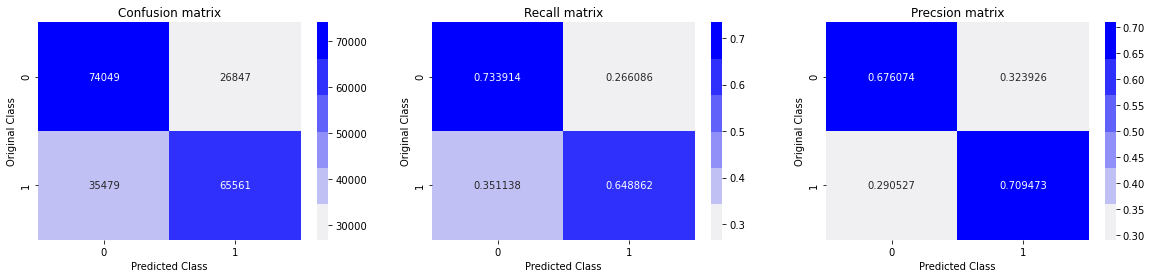

In [116]:
plot_confusion_matrices(predictions_log_reg,y_test.reshape(-1,1))

###### LightGBM classifier

In [117]:
from lightgbm import LGBMClassifier

lgbm_clf= LGBMClassifier(n_jobs = -1,random_state=42,n_estimators=10000)
lgbm_clf.fit(X_tr_set1,y_train)
predictions_lgbm = lgbm_clf.predict(X_ts_set1)
# Use accuracy_score function to get the accuracy
print("LigGBM Accuracy Score -> ",accuracy_score(y_test,predictions_lgbm)*100)

LigGBM Accuracy Score ->  72.0025156485223


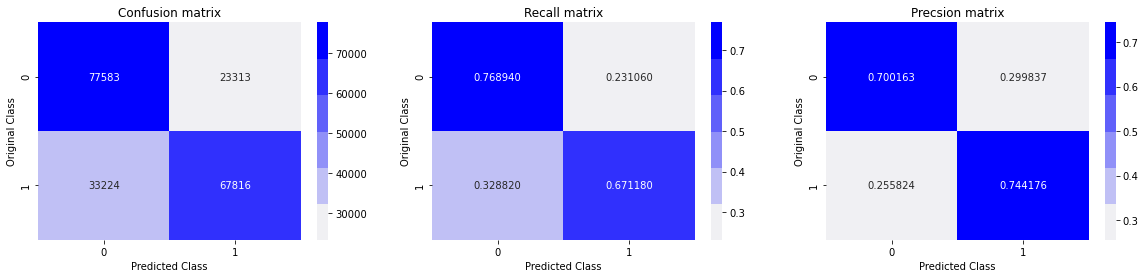

In [118]:
plot_confusion_matrices(predictions_lgbm,y_test.reshape(-1,1))

In [119]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold,StratifiedKFold


In [120]:
y_train[0:1]

array([1], dtype=int64)

In [123]:
def lightgbm_tuning_Bayesian_opt(num_leaves, max_depth,subsample, colsample_bytree, reg_alpha, reg_lambda,learning_rate):
    """
    A function to evaluate the lightgbm for HyperparmeterTuning
    """

    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'learning_rate' : learning_rate,
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'subsample_freq' : 1,
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1
    }
    
    
    
    X_train= X_tr_set1.copy()
    #y_train=y_train.copy()
    lgbm_clf = LGBMClassifier(**params,n_estimators=10000,n_jobs = -1,random_state=42)

    fold = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 33)
    
    cv_pred= np.zeros(y_train.shape[0])
    
    for fold_k,(train_index,val_index) in enumerate(fold.split(X_train,y_train),1):
        
        #print("\t \t Starting K fold validation of fold number : ",fold_k)
        train_x=X_train[train_index]
        train_y=y_train[train_index]
        cv_x=X_train[val_index]
        cv_y=y_train[val_index]

            
        lgbm_clf.fit(train_x,train_y,eval_set=[(cv_x,cv_y)],early_stopping_rounds=100,eval_metric='accuracy',verbose=False)
        
        cv_pred[val_index]= lgbm_clf.predict(cv_x,num_iteration=lgbm_clf.best_iteration_)
        
    return accuracy_score(y_train,cv_pred)

In [ ]:
params = {'colsample_bytree': (0.8, 1), #the fraction of columns to be randomly samples
          'learning_rate': (0.005, 0.01), 
          'num_leaves': (30, 40),  #max leaf nodes
          # 'n_estimators' :(100,10000),  #number of trees
          'subsample': (0.8, 1),  #fraction of observations to be randomly samples for each tree.
          'max_depth': (5, 10),  #maximum depth of a tree
          'reg_alpha': (.03, .05),  #L1 regularization
          'reg_lambda': (.06, .08),#L2 regularization
         }

bopt_lgbm = BayesianOptimization(lightgbm_tuning_Bayesian_opt, params,random_state=42)


bayesian_optimization = bopt_lgbm.maximize(n_iter = 6, init_points = 5)

In [ ]:
best_params=bopt_lgbm.max['params']

best_params


- Retraining with Optimized parameters


In [126]:

best_params['max_depth']= int(round(best_params['max_depth']))
best_params['num_leaves']= int(round(best_params['num_leaves']))
#best_params['min_child_samples']= int(round(best_params['min_child_samples']))

lgbm_clf = LGBMClassifier(**best_params,n_estimators=10000,n_jobs = -1,random_state=42)

In [127]:
lgbm_clf.fit(X_tr_set1,y_train)

LGBMClassifier(n_estimators=10000, random_state=42)

In [128]:
predictions_lgbm = lgbm_clf.predict(X_ts_set1)
# Use accuracy_score function to get the accuracy
print("LightGBM Accuracy Score -> ",accuracy_score(y_test,predictions_lgbm)*100)

LightGBM Accuracy Score ->  72.0025156485223


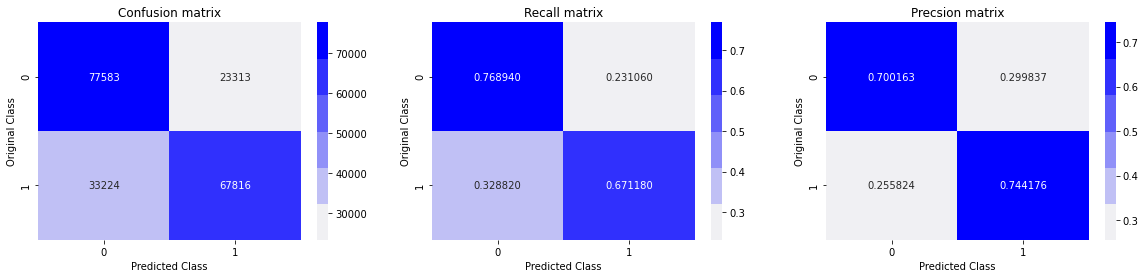

In [129]:
plot_confusion_matrices(predictions_lgbm,y_test.reshape(-1,1))

- It is biased towards FN more

- Lower Recall

- Higher precision model

## RandomForest

In [130]:
from sklearn.ensemble import RandomForestClassifier

params = {'n_jobs' : -1,
    'random_state' : 42,
    'n_estimators' : 10000,
    'class_weight' : 'balanced',
    'verbose' : 0,
    'max_depth': 5}

rf_clf = RandomForestClassifier(**params)
rf_clf.fit(X_tr_set1,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=10000,
                       n_jobs=-1, random_state=42)

In [131]:
predictions_rf = rf_clf.predict(X_ts_set1)
# Use accuracy_score function to get the accuracy
print("Random Forest Accuracy Score -> ",accuracy_score(y_test,predictions_log_reg)*100)

Random Forest Accuracy Score ->  69.13576578718009


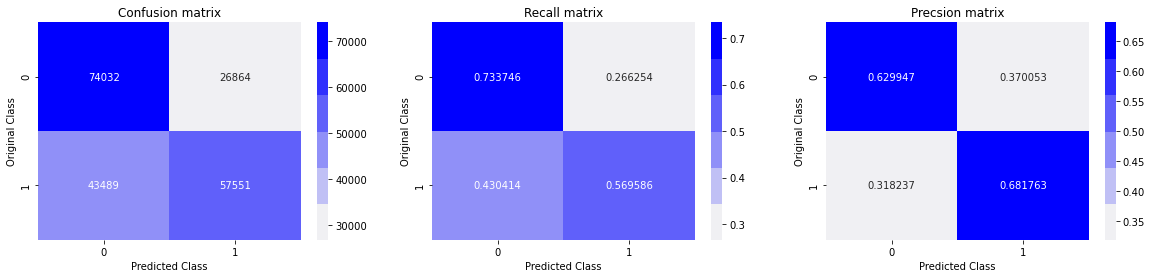

In [132]:
plot_confusion_matrices(predictions_rf,y_test.reshape(-1,1))

###### Similar to LightGBM

- It is biased towards FN more

- Lower Recall

- Higher precision model

In [133]:
## XGBOOST WIth GPU

import xgboost as xgb


In [134]:
from xgboost import XGBClassifier

xgb_clf= XGBClassifier(n_estimators=1000,learning_rate=0.01)

xgb_clf.fit(X_tr_set1,y_train)

[16:10:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [135]:
predictions_xgb_train = xgb_clf.predict(X_tr_set1)
# Use accuracy_score function to get the accuracy
print("XGBoost Train Accuracy Score -> ",accuracy_score(y_train,predictions_xgb_train)*100)

predictions_xgb_test = xgb_clf.predict(X_ts_set1)
# Use accuracy_score function to get the accuracy
print("XGBoost test Accuracy Score -> ",accuracy_score(y_test,predictions_xgb_test)*100)

XGBoost Train Accuracy Score ->  65.94283818347938
XGBoost test Accuracy Score ->  65.70943269154583


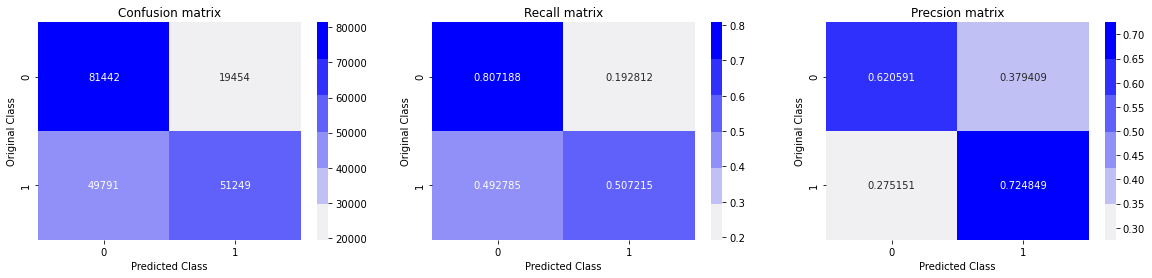

In [136]:
plot_confusion_matrices(predictions_xgb_test,y_test.reshape(-1,1))

#  for set 2

In [137]:
X_tr_set2=joblib.load("X_tr_set2.pkl")
X_ts_set2=joblib.load("X_ts_set2.pkl")

In [138]:
# fit the training dataset on the Logistic Regression classifier
from sklearn.linear_model import LogisticRegression

log_reg= LogisticRegression(C=1,n_jobs=-1,random_state=42,penalty='l2',max_iter=1000)

log_reg.fit(X_tr_set2,y_train)

LogisticRegression(C=1, max_iter=1000, n_jobs=-1, random_state=42)

In [139]:
predictions_log_reg = log_reg.predict(X_ts_set2)
# Use accuracy_score function to get the accuracy
print("Logistic Regression Accuracy Score -> ",accuracy_score(y_test,predictions_log_reg)*100)

Logistic Regression Accuracy Score ->  69.5076657951034


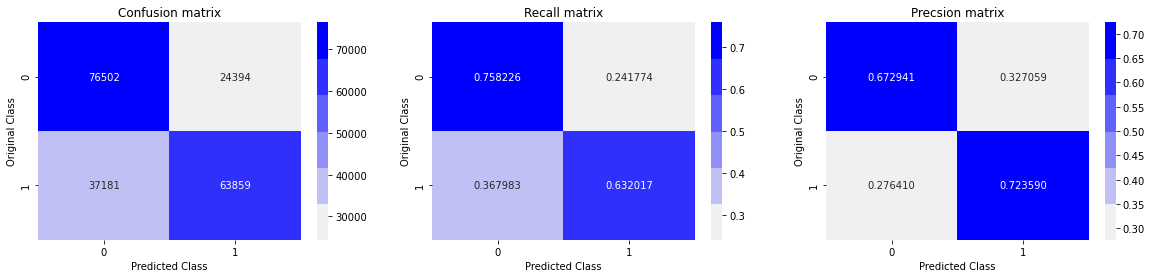

In [140]:
plot_confusion_matrices(predictions_log_reg,y_test.reshape(-1,1))

In [141]:
## little slightly better than Logistric Regression model than set 1.

In [142]:
### LightGBM Classifier

In [143]:
from lightgbm import LGBMClassifier

lgbm_clf= LGBMClassifier(n_jobs = -1,random_state=42,n_estimators=10000)
lgbm_clf.fit(X_tr_set2,y_train)
predictions_lgbm = lgbm_clf.predict(X_ts_set2)
# Use accuracy_score function to get the accuracy
print("LightGBM Accuracy Score -> ",accuracy_score(y_test,predictions_lgbm)*100)

LightGBM Accuracy Score ->  69.40020600586324


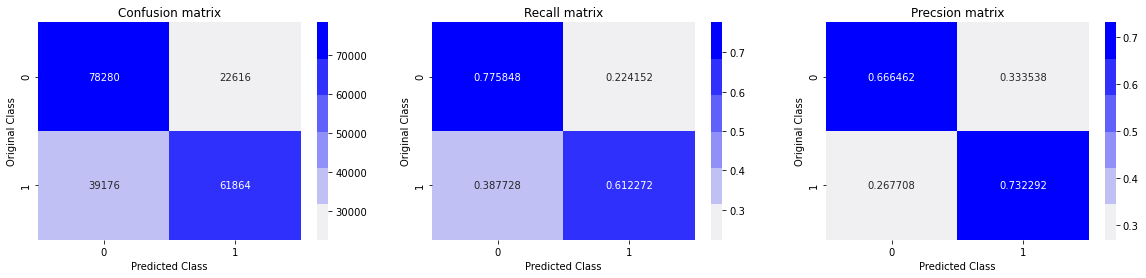

In [144]:
plot_confusion_matrices(predictions_lgbm,y_test.reshape(-1,1))

In [145]:
# http://localhost:8888/notebooks/Desktop/Jupyter_Notebooks/AppliedAiCourse/3%20Foundation_NLP_ML/AmazonFineFood_review_EDA/Amazon_Fine_Food_Reviews_Analysis.ipynb

#### Random Forest Model

In [146]:
from sklearn.ensemble import RandomForestClassifier

params = {'n_jobs' : -1,
    'random_state' : 42,
    'class_weight' : 'balanced',
    'verbose' : 0,
    'max_depth': 5,
          'n_estimators':10000
         }

rf_clf = RandomForestClassifier(**params)
rf_clf.fit(X_tr_set2,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=10000,
                       n_jobs=-1, random_state=42)

In [147]:
predictions_rf = rf_clf.predict(X_ts_set2)
# Use accuracy_score function to get the accuracy
print("RandomForest Accuracy Score -> ",accuracy_score(y_test,predictions_rf)*100)

RandomForest Accuracy Score ->  61.90773314317407


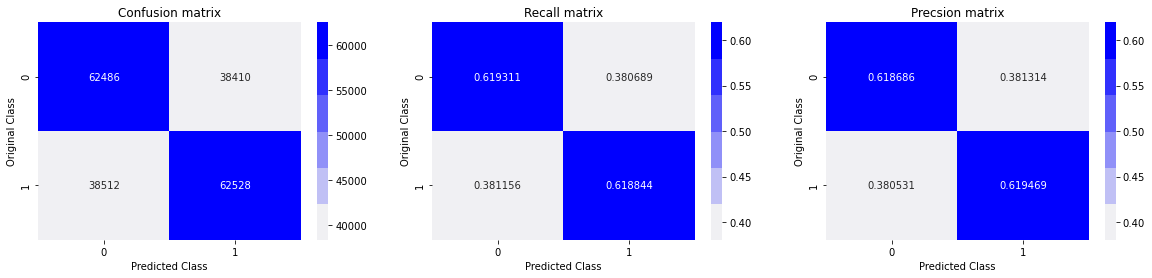

In [148]:
plot_confusion_matrices(predictions_rf,y_test.reshape(-1,1))

In [149]:
## XGBOOST with GPU

In [151]:
%timeit
from xgboost import XGBClassifier

xgb_clf= XGBClassifier(n_estimators=1000,learning_rate=0.01)

xgb_clf.fit(X_tr_set2,y_train)

[16:53:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [152]:

predictions_xgb_train = xgb_clf.predict(X_tr_set2)
# Use accuracy_score function to get the accuracy
print("XGBoost Train Accuracy Score -> ",accuracy_score(y_train,predictions_xgb_train)*100)

predictions_xgb_test = xgb_clf.predict(X_ts_set2)
# Use accuracy_score function to get the accuracy
print("XGBoost test Accuracy Score -> ",accuracy_score(y_test,predictions_xgb_test)*100)

XGBoost Train Accuracy Score ->  60.24275077933301
XGBoost test Accuracy Score ->  59.97197131764519


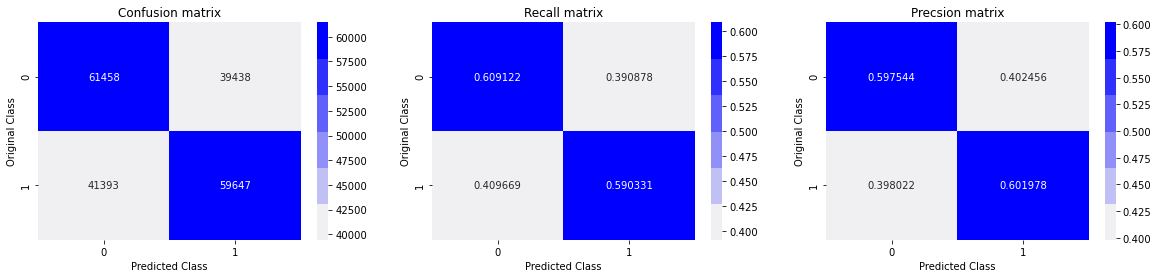

In [153]:
plot_confusion_matrices(predictions_xgb_test,y_test.reshape(-1,1))

#  for set 3

In [154]:
X_tr_set3=joblib.load("X_tr_set3.pkl")
X_ts_set3=joblib.load("X_ts_set3.pkl")

In [155]:
# fit the training dataset on the Logistic  classifier
from sklearn.linear_model import LogisticRegression

log_reg= LogisticRegression(C=1,n_jobs=-1,random_state=42,penalty='l2',max_iter=1000)

log_reg.fit(X_tr_set3,y_train)

LogisticRegression(C=1, max_iter=1000, n_jobs=-1, random_state=42)

In [156]:
predictions_log_reg = log_reg.predict(X_ts_set3)
# Use accuracy_score function to get the accuracy
print("Logistic Regression Accuracy Score -> ",accuracy_score(y_test,predictions_log_reg)*100)

Logistic Regression Accuracy Score ->  69.5076657951034


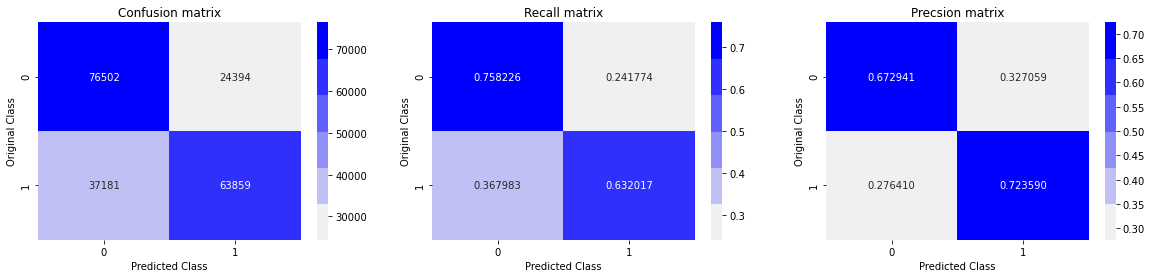

In [157]:
plot_confusion_matrices(predictions_log_reg,y_test.reshape(-1,1))

In [158]:
### lightGBM classifier

In [159]:
from lightgbm import LGBMClassifier

lgbm_clf= LGBMClassifier(n_jobs = -1,random_state=42,n_estimators=10000)
lgbm_clf.fit(X_tr_set3,y_train)
predictions_lgbm = lgbm_clf.predict(X_ts_set3)
# Use accuracy_score function to get the accuracy
print("LightGBM Accuracy Score -> ",accuracy_score(y_test,predictions_lgbm)*100)

LightGBM Accuracy Score ->  69.40020600586324


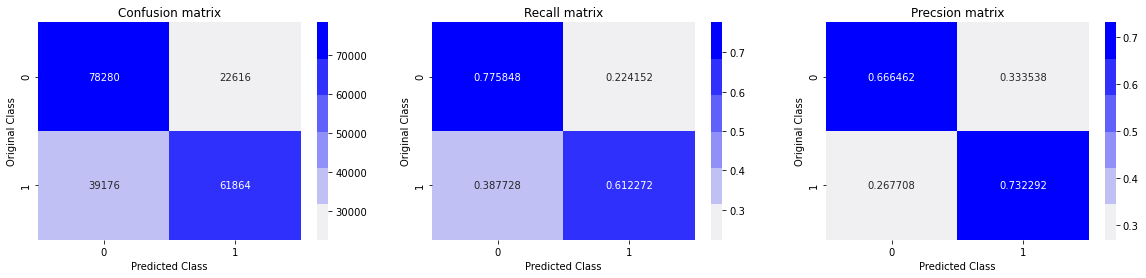

In [160]:
plot_confusion_matrices(predictions_lgbm,y_test.reshape(-1,1))

In [162]:
from sklearn.ensemble import RandomForestClassifier

params = {'n_jobs' : -1,
    'random_state' : 42,
    'class_weight' : 'balanced',
    'n_estimators':10000,
    'verbose' : 0,
    'max_depth': 10}

rf_clf = RandomForestClassifier(**params)
rf_clf.fit(X_tr_set3,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       n_estimators=10000, n_jobs=-1, random_state=42)

In [163]:
predictions_rf_clf = rf_clf.predict(X_ts_set3)
# Use accuracy_score function to get the accuracy
print("RandomForest Accuracy Score -> ",accuracy_score(y_test,predictions_rf_clf)*100)

RandomForest Accuracy Score ->  62.61934474288884


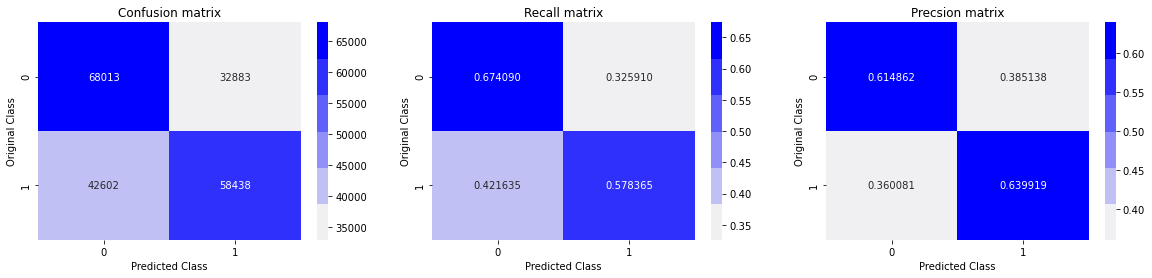

In [164]:
plot_confusion_matrices(predictions_rf_clf,y_test.reshape(-1,1))

# using LSTM

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [169]:
num_words = 500
#This will be the maximum number of words from our resulting tokenized data vocabulary which are to be used,
#truncated after the 500 most common words in our case. 
#This will not be an issue in our small dataset, but is being shown for demonstration purposes
oov_token = '<UNK>'
#This is the token which will be used for out of vocabulary tokens encountered during the tokenizing
#and encoding of test data sequences, created using the word index built during tokenization of our
#training data.

pad_type = 'post'
# When we are encoding our numeric sequence representations of the text data, 
# our sentences (or arbitrary text chunk) lengths will not be uniform, and so we will need to select
# a maximum length for sentences and pad unused sentence positions in shorter sentences with a 
# padding character. In our case, our maximum sentence length will be determined by searching 
# our sentences for the one of maximum length,  and padding characters will be '0'.

trunc_type = 'post'

# As in the above, when we are encoding our numeric sequence representations of the text data, 
# our sentences (or arbitrary text chunk) lengths will not be uniform, and so we will need to 
# select a maximum length for sentences and pad unused sentence positions in shorter sentences with a 
# padding character. Whether we pre-pad or post-pad sentences is our decision to make, 
# and we have selected 'post', meaning that our sentence sequence numeric representations corresponding 
# to word index entries will appear at the left-most positions of our resulting sentence vectors, 
# while the padding characters ('0') will appear after our actual data at the right-most positions of 
# our resulting sentence vectors.

In [170]:
# Tokenize our training data
tokenizer= Tokenizer(num_words=num_words,oov_token=oov_token)
tokenizer.fit_on_texts(train_df['clean_comment'])

In [171]:
# Get our training data word index
word_index = tokenizer.word_index

In [172]:
len(word_index)

147327

In [173]:
# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(train_df['clean_comment'])

In [174]:
#lets take 
max_seq_len=40

In [175]:
# Pad the training sequences
train_sequences_padded= pad_sequences(train_sequences,padding=pad_type,truncating=trunc_type,maxlen=max_seq_len)

In [176]:
len(train_sequences_padded[0])

40

In [177]:
print('Shape of data tensor:', train_sequences_padded.shape)

Shape of data tensor: (807742, 40)


In [178]:
print("\nTraining sequences at index 0:\n", train_sequences[0])
print("\nPadded training sequences at index 0:\n", train_sequences_padded[0])
print("\nPadded training shape:", train_sequences_padded.shape)
print("Training sequences data type:", type(train_sequences))
print("Padded Training sequences data type:", type(train_sequences_padded))


Training sequences at index 0:
 [37, 1, 10, 26, 1, 27, 1]

Padded training sequences at index 0:
 [37  1 10 26  1 27  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]

Padded training shape: (807742, 40)
Training sequences data type: <class 'list'>
Padded Training sequences data type: <class 'numpy.ndarray'>


In [179]:
#lets do same for test data
test_sequences = tokenizer.texts_to_sequences(test_df['clean_comment'])
test_sequences_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=max_seq_len)

print("Testing sequences at index 0:\n", test_sequences[0])
print("\nPadded testing sequences at index 0 :\n", test_sequences_padded[0])
print("\nPadded testing shape:",test_sequences_padded.shape)

Testing sequences at index 0:
 [35, 12, 3, 1, 248]

Padded testing sequences at index 0 :
 [ 35  12   3   1 248   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]

Padded testing shape: (201936, 40)


In [ ]:
#our next step is to create an embedding matrix from the precomputed Glove embeddings

In [ ]:
import numpy as np
embeddings_index = {}
f = open('glove.42B.300d.txt',encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs#glove vector for the words
f.close()

print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
#now we will create the embedding Matrix
import numpy as np
embedding_matrix= np.zeros((len(word_index)+1,300))
#
for word,i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        #not founded would be zeros as we have zero's matrix already
        embedding_matrix[i]= embedding_vector

In [ ]:
import joblib
joblib.dump(embedding_matrix,'embedding_matrix.pkl')

In [180]:
import joblib
embedding_matrix=joblib.load('embedding_matrix.pkl')

In [181]:
embedding_matrix.shape

(147328, 300)

In [182]:
len(word_index)#this word index will have all words in corpus and its freq

147327

In [12]:
## One hot encoding traget columns
from tensorflow.keras.utils import to_categorical

y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding,Dense,SpatialDropout1D,Dense,LeakyReLU,Input,LSTM,Flatten,concatenate,Dropout
from keras import Model
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.regularizers import l1,l2

In [185]:
input_1= Input(shape=(40,))
embedding_1=Embedding(input_dim=embedding_matrix.shape[0],
                          output_dim=300,
                         weights=[embedding_matrix],
                         trainable=False)(input_1)

drop_out=SpatialDropout1D(0.3)(embedding_1)

lstm1= LSTM(128,return_sequences=True)(drop_out)

flatten1= Flatten()(lstm1)

#now the model is just sequential
x=Dense(256,kernel_initializer=he_normal(),activation='relu',kernel_regularizer=l1(0.0001))(flatten1)
x = Dropout(0.5)(x)
x = Dense(128,kernel_initializer=he_normal(),activation='relu',kernel_regularizer=l1(0.0001))(x)
x = Dropout(0.5)(x)
x = Dense(128,kernel_initializer=he_normal(),activation='relu',kernel_regularizer=l1(0.0001))(x)
#x= Dropout(0.5)(x)
output = Dense(2, activation = 'softmax')(x)

In [186]:
#creating model based on above layers

model_lstm= Model(inputs=input_1,outputs=output)
#model1.run_eagerly = True
model_lstm.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,decay = 1e-4),metrics=['accuracy'])
print(model_lstm.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 40, 300)           44198400  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 40, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 40, 128)           219648    
_________________________________________________________________
flatten (Flatten)            (None, 5120)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1310976   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0   

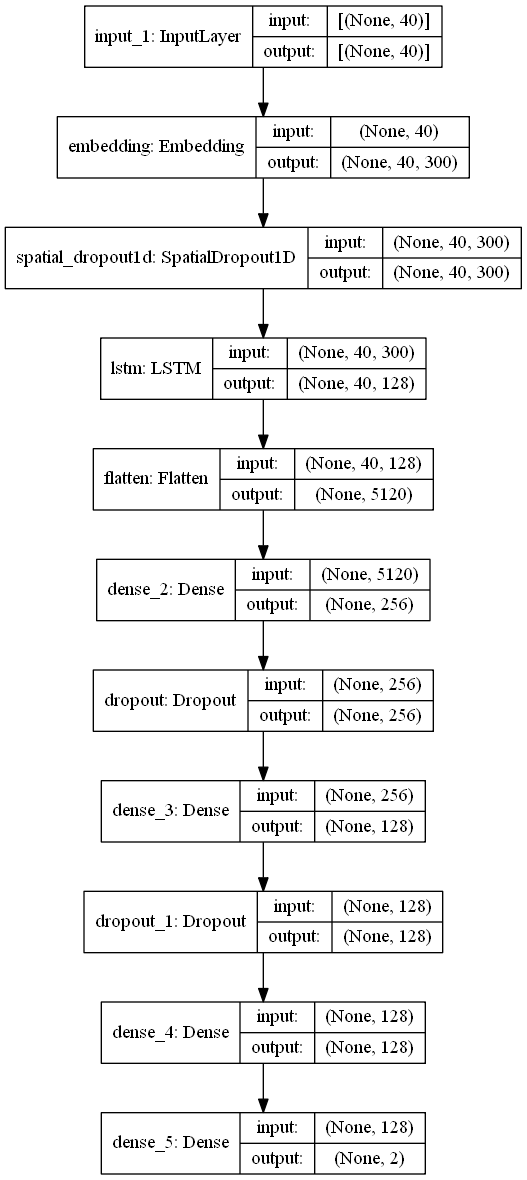

In [187]:
from keras.utils.vis_utils import plot_model
plot_model(model_lstm, to_file='model_ltsm.png', show_shapes=True, show_layer_names=True)

In [188]:
import os
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping,ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore") 
#creating tensboard call back object
log_dir = os.path.join('logs1','fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
filepath = "best_lstm_model.hdf5"
#history_loss= LossHistory(validation_data=validation_data)
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping_1 = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1,mode="max")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
reduce_lr= ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=1, verbose=0,mode='max', min_delta=0.01, cooldown=0, min_lr=0.0001)
callbacks_list=[checkpoint,earlystopping_1,reduce_lr,tensorboard_callback]

- cooldown parameter in RedueLROnPlateu
it does not state it clearly in the description. What it means is that if you set a cooldown you have to wait before resuming normal operation (i.e. beginning to monitor if there is any improvement in the monitored metric over a patience epochs).

For example, let's say cooldown=5. After the learning rate is reduced, the algorithm waits 5 epochs before starting to monitor the metrics again. So if there is no improvement in the metric and patience=10, the learning rate will be reduced again after 15 epochs.

In [189]:
model_lstm.fit(train_sequences_padded,y_train_ohe,batch_size=256,epochs=50,verbose=1,validation_data=(test_sequences_padded,y_test_ohe),callbacks=callbacks_list)

Epoch 1/50
3156/3156 [==============================] - 104s 32ms/step - loss: 0.7128 - accuracy: 0.6599 - val_loss: 0.6217 - val_accuracy: 0.6866

Epoch 00001: val_accuracy improved from -inf to 0.68664, saving model to best_lstm_model.hdf5
Epoch 2/50
3156/3156 [==============================] - 99s 31ms/step - loss: 0.6233 - accuracy: 0.6847 - val_loss: 0.6128 - val_accuracy: 0.6933

Epoch 00002: val_accuracy improved from 0.68664 to 0.69332, saving model to best_lstm_model.hdf5
Epoch 3/50
3156/3156 [==============================] - 99s 31ms/step - loss: 0.5993 - accuracy: 0.6936 - val_loss: 0.5901 - val_accuracy: 0.7004

Epoch 00003: val_accuracy improved from 0.69332 to 0.70044, saving model to best_lstm_model.hdf5
Epoch 4/50
3156/3156 [==============================] - 106s 34ms/step - loss: 0.5931 - accuracy: 0.6972 - val_loss: 0.5881 - val_accuracy: 0.7021

Epoch 00004: val_accuracy improved from 0.70044 to 0.70214, saving model to best_lstm_model.hdf5
Epoch 5/50
3156/3156 [===

In [190]:
model_lstm.save("model_lstm.h5")

In [191]:
modellstm= tf.keras.models.load_model("model_lstm.h5")

In [204]:
test_predictions = model_lstm.predict(x=test_sequences_padded, batch_size=256,verbose=1)

789/789 [==============================] - 9s 11ms/step


In [214]:
test_pred_labels = [np.argmax(label) for label in test_predictions]

In [216]:
len(test_pred_labels)

201936

In [217]:
from sklearn.metrics import confusion_matrix, classification_report

print('Classification Report:')
print(classification_report(y_true=y_test, y_pred=test_pred_labels))

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.77      0.72    100896
           1       0.74      0.64      0.69    101040

    accuracy                           0.71    201936
   macro avg       0.71      0.71      0.71    201936
weighted avg       0.71      0.71      0.71    201936



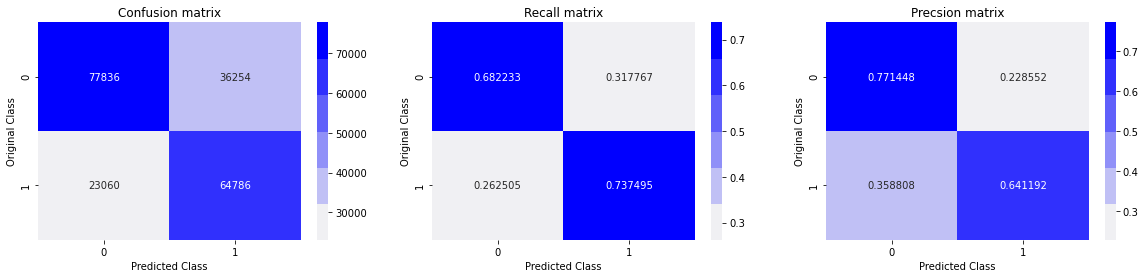

In [220]:
plot_confusion_matrices(y_test, test_pred_labels)

#### Pre trained bert model

In [12]:

import tensorflow_hub as hub

In [13]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have, for now i am making it as 55. You can change this
max_seq_length = 40

#BERT takes 3 inputs

#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

bert_inputs = [input_word_ids, input_mask, segment_ids]

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
bert_output,_= bert_layer(bert_inputs)
dense = tf.keras.layers.Dense(256, activation='relu')(bert_output)
pred = tf.keras.layers.Dense(2, activation='softmax')(dense)

bert_model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)

In [14]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 40)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 40)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [15]:
#getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [16]:
from bert.tokenization import bert_tokenization
tokenizer=bert_tokenization.FullTokenizer(vocab_file,do_lower_case)

In [17]:

def create_tokens_mask_segment(text,tokenizer,max_seq_length):
    
    tokens_list=[]
    masks_list=[]
    segments_list=[]
    
    for txt in text:
        #Create text tokens using Tokenizer
        txt= tokenizer.tokenize(txt)
        
        # add '[CLS]' at start of the Tokens and '[SEP]' at the end of the tokens. 
        # maximum number of tokens is 55(We already given this to BERT layer above) so shape is (None, 55)
        # if it is less than 55, add '[PAD]' token else truncate the tokens length.(similar to padding)
        txt=['[CLS]']+txt
        #we will add [SEP] at end but we need to ensure that length is 55,so we have added [cls],
        #we will decrease len by two : 1 from start and 1 by end till the max seq length dont affect
        input_sentence= txt[:max_seq_length-2]+['[SEP]']
        ## if it is less than 55, add '[PAD]' token else truncate the tokens length.(similar to padding)
        len_padding= max_seq_length- len(input_sentence)
        # Based on padding, create the mask for Train and Test ( 1 for real token, 0 for '[PAD]'), 
        padding_masks= [1]* len(input_sentence) + [0]*len_padding
        # it will also same shape as input tokens (None, 55) save those in X_train_mask, X_test_mask
        #converting convert_tokens_to_ids with padding
        new_tokens=tokenizer.convert_tokens_to_ids(input_sentence)+[0]*len_padding
        # Create a segment input for train and test. We are using only one sentence so all zeros. This shape will also (None, 55)

        segment_ids= [0]*max_seq_length
        
        tokens_list.append(new_tokens)
        masks_list.append(padding_masks)
        segments_list.append(segment_ids)
    
    #type of all the above arrays should be numpy arrays
    return np.array(tokens_list),np.array(masks_list),np.array(segments_list)


In [17]:
X_train_tokens, X_train_mask, X_train_segment= create_tokens_mask_segment(train_df['clean_comment'],tokenizer,max_seq_length)
X_test_tokens, X_test_mask, X_test_segment= create_tokens_mask_segment(test_df['clean_comment'],tokenizer,max_seq_length)

In [18]:
import pickle

##save all your results to disk so that, no need to run all again. 
pickle.dump((train_df['clean_comment'], X_train_tokens, X_train_mask, X_train_segment, y_train_ohe),open('train_data_bert.pkl','wb'))
pickle.dump((test_df['clean_comment'], X_test_tokens, X_test_mask, X_test_segment, y_test_ohe),open('test_data_bert.pkl','wb'))

#you can load from disk
X_train, X_train_tokens, X_train_mask, X_train_segment, y_train_ohe = pickle.load(open("train_data_bert.pkl", 'rb')) 
X_test, X_test_tokens, X_test_mask, X_test_segment, y_test_ohe = pickle.load(open("test_data_bert.pkl", 'rb')) 

In [12]:
import pickle
#you can load from disk
X_train, X_train_tokens, X_train_mask, X_train_segment, y_train_ohe = pickle.load(open("train_data_bert.pkl", 'rb')) 
X_test, X_test_tokens, X_test_mask, X_test_segment, y_test_ohe = pickle.load(open("test_data_bert.pkl", 'rb')) 

In [13]:
X_train.iloc[0]

'your argument is just flooding with merit'

In [19]:
X_train_tokens[0]

array([ 101, 2115, 6685, 2003, 2074, 9451, 2007, 7857,  102,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

In [20]:
bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [21]:
import os
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping,ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore") 
#creating tensboard call back object
log_dir = os.path.join('logs2','fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
filepath = "best_bert_model.hdf5"
#history_loss= LossHistory(validation_data=validation_data)
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping_1 = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1,mode="max")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
reduce_lr= ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=1, verbose=0,mode='max', min_delta=0.01, cooldown=0, min_lr=0.0001)
callbacks_list=[checkpoint,earlystopping_1,reduce_lr,tensorboard_callback]

In [22]:
y_test_ohe.shape

(201936, 2)

In [23]:
#tf.config.run_functions_eagerly(True)
bert_model.fit([X_train_tokens, X_train_mask, X_train_segment],y_train_ohe,
    validation_data=([X_test_tokens, X_test_mask, X_test_segment], y_test_ohe),
    epochs=2,
    batch_size=256,
    verbose=1,callbacks=callbacks_list
)

Epoch 1/2
3156/3156 [==============================] - 2262s 714ms/step - loss: 0.6375 - accuracy: 0.6338 - val_loss: 0.6471 - val_accuracy: 0.6299

Epoch 00001: val_accuracy improved from -inf to 0.62987, saving model to best_bert_model.hdf5
Epoch 2/2
3156/3156 [==============================] - 2490s 789ms/step - loss: 0.6183 - accuracy: 0.6527 - val_loss: 0.6100 - val_accuracy: 0.6606

Epoch 00002: val_accuracy improved from 0.62987 to 0.66059, saving model to best_bert_model.hdf5


In [ ]:
## P

In [8]:
import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import pickle

In [15]:
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 40

comment = train_df.iloc[0][0]

tkzr = DistilBertTokenizer.from_pretrained(MODEL_NAME)

inputs = tkzr(comment, max_length=MAX_LEN, truncation=True, padding=True)

print(f'review: \'{comment}\'')
print(f'input ids: {inputs["input_ids"]}')
print(f'attention mask: {inputs["attention_mask"]}')

review: 'your argument is just flooding with merit'
input ids: [101, 2115, 6685, 2003, 2074, 9451, 2007, 7857, 102]
attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1]


In [16]:
def construct_encodings(x, tkzr, max_len, trucation=True, padding=True):
    return tkzr(x, max_length=max_len, truncation=trucation, padding=padding)
    
encodings = construct_encodings(list(train_df.values.flatten()), tkzr, max_len=MAX_LEN)

In [17]:
def construct_tfdataset(encodings, y=None):
    if y.any():
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))
    
tfdataset = construct_tfdataset(encodings, y_train)

### Fine-tuning the model

In [18]:
CV_SPLIT = 0.2
BATCH_SIZE = 64

train_size = int(len(train_df) * (1-CV_SPLIT))

tfdataset = tfdataset.shuffle(len(train_df))
tfdataset_train = tfdataset.take(train_size)
tfdataset_cv = tfdataset.skip(train_size)

tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_cv = tfdataset_cv.batch(BATCH_SIZE)

In [21]:
N_EPOCHS = 2

model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME)
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model.fit(tfdataset_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_39', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/2
10097/10097 [==============================] - 9347s 925ms/step - loss: 0.5274 - accuracy: 0.7335
Epoch 2/2
10097/10097 [==============================] - 10007s 991ms/step - loss: 0.4711 - accuracy: 0.7739


In [51]:
benchmarks_cv = model.evaluate(tfdataset_cv, return_dict=True, batch_size=BATCH_SIZE)
print(benchmarks_cv)

2525/2525 [==============================] - 690s 273ms/step - loss: 0.4002 - accuracy: 0.8214
{'loss': 0.4002488851547241, 'accuracy': 0.8213792443275452}


In [24]:
encodings_test = construct_encodings(list(test_df.values.flatten()), tkzr, max_len=MAX_LEN)

In [25]:
tfdataset_test = construct_tfdataset(encodings_test, y_test)

In [26]:
BATCH_SIZE = 64

tfdataset_test = tfdataset_test.shuffle(len(test_df))

tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

In [27]:
test_benchmarks = model.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE)
print(test_benchmarks)

3156/3156 [==============================] - 488s 154ms/step - loss: 0.4980 - accuracy: 0.7574
{'loss': 0.4979688823223114, 'accuracy': 0.7573637366294861}


In [139]:
def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))

In [140]:
def create_predictor(model, model_name, max_len):
    
    tkzr = DistilBertTokenizer.from_pretrained(model_name)
    
    def predict_proba(text):
        x = [text]

        encodings = construct_encodings(x, tkzr, max_len=max_len)
        tfdataset = construct_tfdataset(encodings)
        tfdataset = tfdataset.batch(1)

        preds = model.predict(tfdataset).logits
        preds = activations.softmax(tf.convert_to_tensor(preds)).numpy()
        return 1 if preds[0][0]<0.5 else 0
    
    return predict_proba

clf = create_predictor(model, MODEL_NAME, MAX_LEN)

In [126]:
#lets check for some points

In [127]:
check_df=df.sample(n=10)

In [128]:
check_df

,label,clean_comment
52649,1,if i buy them in pairs can i have a threesome with exceptionally attractive bisexual fembots
841588,1,obviously professional feedback here guise i m sure that flair is accurate
379422,1,gee that doesn t sound like opportunistic political expediency at all i mean any truly liberal person would jump at the chance to campaign for a conservative as long as it allowed them to be involved with politics
724162,1,no doubt poverty is to blame
121298,1,been an hour since the last pic of this same 4 batman pops was posted i was starting to worry
634886,0,heforshitheads
744557,1,plot twist pro kpk paid them to say that to further reduce bg reputation or whatever left on him
63953,0,anyone know where i can get one in the uk that doesn t cost an arm and a leg
802438,1,objective morality is such a bad thing right
355090,0,seeing as it s dead it s obviously the patriarchy


In [143]:
print(f"real***predicted*****comment")

for i,row in df.sample(10).iterrows():
    
    print(f"{row['label']} ***{clf(row['clean_comment'])}*****{row['clean_comment']}")


#clf("values as in capitalism there is good money in imprisoning people")

real***predicted*****comment
1 ***1*****yes we should become a rv nation
1 ***1*****yeah that worked out real well in gaza
1 ***1*****it s the government if you can t trust them who can you trust
0 ***0*****1 blatt please
1 ***1*****it s not possible to be ableist against white people because ableism is privilege power which all white people have
1 ***1*****wow that s an amazing accomplishment
0 ***0*****and having a gun and not
0 ***0*****just reached him fuck my life
0 ***1*****see all i can think about is african deer like animals but you do you
0 ***0*****drivers have also proven proficiency to whatever standard has been deemed acceptable to the state they are licensed in


In [144]:
#This looks good

In [142]:
model.save_pretrained('./model/clf_distilBert')
with open('./model/info.pkl', 'wb') as f:
    pickle.dump((MODEL_NAME, MAX_LEN), f)

In [22]:
model = TFDistilBertForSequenceClassification.from_pretrained('./model/clf_distilBert')
model_name, max_len = pickle.load(open('./model/info.pkl', 'rb'))

Some layers from the model checkpoint at ./model/clf_distilBert were not used when initializing TFDistilBertForSequenceClassification: ['dropout_39']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./model/clf_distilBert and are newly initialized: ['dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://github.com/peterbayerle/huggingface_notebook/blob/main/distilbert_tf.ipynb

https://www.section.io/engineering-education/classification-model-using-bert-and-tensorflow/

In [13]:
from sklearn.model_selection import train_test_split
X= data['comment'].values
y= data['label'].values
train_df, test_df, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,random_state=42)

In [14]:
import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import pickle

In [16]:
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 40

review1 = train_df[20]

tkzr1 = DistilBertTokenizer.from_pretrained(MODEL_NAME,num_labels=2)

inputs1 = tkzr1(review1, max_length=MAX_LEN, truncation=True, padding=True)

print(f'review: \'{review1}\'')
print(f'input ids: {inputs1["input_ids"]}')
print(f'attention mask: {inputs1["attention_mask"]}')

review: 'As God intended.'
input ids: [101, 2004, 2643, 3832, 1012, 102]
attention mask: [1, 1, 1, 1, 1, 1]


In [17]:
def construct_encodings(x, tkzr, max_len, trucation=True, padding=True):
    return tkzr(x, max_length=max_len, truncation=trucation, padding=padding)


encodings = construct_encodings(list(train_df.flatten()), tkzr1, max_len=MAX_LEN)

In [18]:
# from tqdm import tqdm
# encodings=[]
# for i in tqdm(list(train_df.flatten())):
#         encodings.append(construct_encodings(i, tkzr1, max_len=MAX_LEN))    

In [19]:
def construct_tfdataset(encodings, y=None):
    if y.any():
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))
    
tfdataset1 = construct_tfdataset(encodings, y_train)

In [20]:
TEST_SPLIT = 0.2
BATCH_SIZE = 64

train_size = int(len(train_df) * (1-TEST_SPLIT))

tfdataset1 = tfdataset1.shuffle(len(train_df))
tfdataset_train1 = tfdataset1.take(train_size)
tfdataset_cv1 = tfdataset1.skip(train_size)

tfdataset_train1 = tfdataset_train1.batch(BATCH_SIZE)
tfdataset_cv1 = tfdataset_cv1.batch(BATCH_SIZE)

In [21]:
N_EPOCHS = 2

model_no_clean = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=2)
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model_no_clean.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model_no_clean.fit(tfdataset_train1, batch_size=BATCH_SIZE, epochs=N_EPOCHS)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/2
10108/10108 [==============================] - 4811s 475ms/step - loss: 0.5080 - accuracy: 0.7476
Epoch 2/2
10108/10108 [==============================] - 1718s 170ms/step - loss: 0.4525 - accuracy: 0.7858


In [22]:
benchmarks_cv1 = model_no_clean.evaluate(tfdataset_cv1, return_dict=True, batch_size=BATCH_SIZE)
print(benchmarks_cv1)

2527/2527 [==============================] - 683s 269ms/step - loss: 0.3898 - accuracy: 0.8272
{'loss': 0.3897581100463867, 'accuracy': 0.8271932601928711}


In [ ]:
encodings = construct_encodings(list(test_df.flatten()), tkzr1, max_len=MAX_LEN)

In [29]:
def construct_tfdataset(encodings, y=None):
    if y.any():
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))
    

In [27]:
encodings_test1 = construct_encodings(list(test_df.flatten()), tkzr1, max_len=MAX_LEN)

In [36]:
test_tfdataset1 = construct_tfdataset(encodings_test1, y_test.reshape(-1,1))

In [37]:
BATCH_SIZE = 64

test_tfdataset1 = test_tfdataset1.shuffle(len(test_df))

test_tfdataset1 = test_tfdataset1.batch(BATCH_SIZE)

In [38]:
test_benchmarks = model_no_clean.evaluate(test_tfdataset1, return_dict=True, batch_size=BATCH_SIZE)
print(test_benchmarks)

3159/3159 [==============================] - 854s 270ms/step - loss: 0.4777 - accuracy: 0.7710
{'loss': 0.47769439220428467, 'accuracy': 0.7710222601890564}


In [66]:
model_no_clean.save_pretrained('./model/clf_distilBert_no_clean')
with open('./model/clf_distilBert2/info.pkl', 'wb') as f:
    pickle.dump((MODEL_NAME, MAX_LEN), f)

In [40]:
test_predictions = model_no_clean.predict(x=test_tfdataset1, batch_size=256,verbose=1)

3159/3159 [==============================] - 877s 277ms/step


In [43]:
preds=test_predictions.logits

In [44]:
preds = activations.softmax(tf.convert_to_tensor(preds)).numpy()

In [45]:
preds

array([[0.020307  , 0.97969306],
       [0.00251561, 0.9974843 ],
       [0.32970044, 0.67029953],
       ...,
       [0.8276382 , 0.1723618 ],
       [0.73430276, 0.26569724],
       [0.7240093 , 0.27599072]], dtype=float32)

In [46]:


test_pred_labels = [np.argmax(label) for label in preds]

len(test_pred_labels)


202155

In [49]:
def create_predictor(model, model_name, max_len):
    
    tkzr = DistilBertTokenizer.from_pretrained(model_name)
    
    def predict_proba(text):
        x = [text]

        encodings = construct_encodings(x, tkzr, max_len=max_len)
        tfdataset = construct_tfdataset(encodings)
        tfdataset = tfdataset.batch(1)

        preds = model.predict(tfdataset).logits
        preds = activations.softmax(tf.convert_to_tensor(preds)).numpy()
        return 1 if preds[0][0]<0.5 else 0
    
    return predict_proba

clf = create_predictor(model_no_clean, MODEL_NAME, MAX_LEN)

In [52]:
def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))

In [53]:
print(f"real***predicted*****comment")

for i,row in data.sample(10).iterrows():
    
    print(f"{row['label']} ***{clf(row['comment'])}*****{row['comment']}")

real***predicted*****comment
1 ***1*****You mean he doesnt get to retroactively remove consent like women with buyers remorse are allowed to?
0 ***0*****...what?
0 ***0*****Jebus will save us this time.
1 ***0*****Why don't you fucking do it
0 ***0*****No I just think Mariota is promising.
0 ***0*****Correct me if I'm wrong but I thought C3P0 and R2D2 got their footprints on the walk of fame before Empire even came out?
1 ***1*****But if you did that, you'd be racist!
1 ***1*****Yeah everyone loves it when people surprise them at their doorstep.
0 ***0*****And yet another extremist fanatic goes on a terroristic rampage because they disagree with how people live their lives.
1 ***1*****Yes, because this one video will be the lasting memory for all leaguers on what Darien was known for


In [27]:
result_compare = pd.DataFrame([['Logistic Regression',"Bag of word(Unigram)+sentiment_score","-","-" ,0.691,],
                               ['LightGBM Classifier',"Bag of word(Unigram)+sentiment_score","-","-" ,0.720],
                               ['RandomForest Classifier',"Bag of word(Unigram)+sentiment_score","-","-" ,0.69],
                               ['XGBoost Classifier',"Bag of word(Unigram)+sentiment_score","0.659","-" ,0.657],
                               ['Logistic Regression',"Bag of word(Bigram)+sentiment_score","-","-" ,0.695,],
                               ['LightGBM Classifier',"Bag of word(Bigram)+sentiment_score","-","-" ,0.694],
                               ['RandomForest Classifier',"Bag of word(Bigram)+sentiment_score","-","-" ,0.619],
                               ['XGBoost Classifier',"Bag of word(Bigram)+sentiment_score","0.602","-" ,0.599],
                               ['Logistic Regression',"TF-IDF(Uni+Bigram)+sentiment_score","-","-" ,0.695,],
                               ['LightGBM Classifier',"TF-IDF(Uni+Bigram)+sentiment_score","-","-" ,0.694],
                               ['RandomForest Classifier',"TF-IDF(Uni+Bigram)+sentiment_score","-","-" ,0.626],
                               ['LSTM+Dense',"Text_sequnece_padded",0.705,"-" ,0.710],
                               ['bert_pretained_model',"Bert Tokeinizer",0.652,"-" ,0.660],
                               ['TFDistilBertForSequenceClassification',"DistilBertTokenizer(for cleaned text)",0.773,0.821 ,0.757],
                               ['TFDistilBertForSequenceClassification',"DistilBertTokenizer(without cleaned text)",0.785,0.827 ,0.771]],
                              columns = ['Model_Name','Text Features Type',"Train Acccurcay","CV_accuracy","Test_accuracy" ], index = list(range(1,16)))

display(result_compare)

,Model_Name,Text Features Type,Train Acccurcay,CV_accuracy,Test_accuracy
1,Logistic Regression,Bag of word(Unigram)+sentiment_score,-,-,0.691
2,LightGBM Classifier,Bag of word(Unigram)+sentiment_score,-,-,0.720
3,RandomForest Classifier,Bag of word(Unigram)+sentiment_score,-,-,0.690
4,XGBoost Classifier,Bag of word(Unigram)+sentiment_score,0.659,-,0.657
5,Logistic Regression,Bag of word(Bigram)+sentiment_score,-,-,0.695
6,LightGBM Classifier,Bag of word(Bigram)+sentiment_score,-,-,0.694
7,RandomForest Classifier,Bag of word(Bigram)+sentiment_score,-,-,0.619
8,XGBoost Classifier,Bag of word(Bigram)+sentiment_score,0.602,-,0.599
9,Logistic Regression,TF-IDF(Uni+Bigram)+sentiment_score,-,-,0.695
10,LightGBM Classifier,TF-IDF(Uni+Bigram)+sentiment_score,-,-,0.694


# Final Observations

- So we can see in Classical Machine learning models  LightGBM classifier with Bag of word(Unigram)+sentiment_score features has best accuracy.



- lstm with a simple neural network worked really well on this ,but still slightly behind the LightGBM with BOW unigram and sent. score.



- Pre trained Bert model couldnt performed well,This might be due to cleaned text as well.



- I tried to train the bert model with scratch but It only allowed with batch size 16 ,So for single epoch it was taking 9 hours.So i couldn't able to try it. 

**PS: I have a pretty decent system with 16GB RAM,i7 octa core ,NVIDIA RTX 3060 GPU with 6GB DDR6**



- I have also tried pre-train and Fine tuned the TFDistilBertForSequenceClassification pretrained model from hugging face.



 - With cleaned text it performed well, So I tried to train and fine tune the model directly with just comment raw text,It really has done well.. This is because usually pretained bert_models try to learn the whole essense of data without cleaning.
 
 
 
- I haven't trained the transfer learning models with more epoch as we can see the for single epoch it is taking 3 hours (even with GPU overclocking)




- So i think my final pre trained and fine Tuned model **TFDistilBertForSequenceClassification	with DistilBertTokenizer(without cleaned text) is the winner here.**
